In [1]:
import numpy as np
from scipy.stats import gamma, uniform
from math import e, log, pi, sin, cos, asin, atan2, exp
import random

## Setup data
1. We use 300 random samples with a set random state to ensure we always get the same repro data.
2. We standard scale to ensure the same distance between different stats

In [2]:
from sklearn.datasets._samples_generator import make_blobs
X, y_true = make_blobs(n_samples=50, centers=4, n_features=2,
                       cluster_std=0.60, random_state=0)

In [3]:
import pandas as pd 

df = pd.DataFrame(X)
df.head()

,0,1
0,0.914339,4.550146
1,-1.930380,2.702150
2,1.872718,4.180692
3,-0.555524,4.695958
4,-1.034436,8.259404


In [4]:
max_value = np.max(X)
max_value

9.00163272703117

## Math

- Radius $r$
- Privacy level $l$ within $r$
- The differential privacy is reached using $\epsilon = l/r$
- $X$ = Points of interest
- $Z$ = Possible reported values
- For every $x \in X $ we report a perturbed point $z \in Z$


Finding the "perfect" radius not as easy as with the cartesian system. We don't have the notion of unit like meter or km; so we can't really determine on a fixed value for the radius.
This radius is however not used in the calculations, but only used to calculate the privacy budget $\epsilon$. Which means it is more importently to get the epsilon right. 
Therefore, we will experiment with three different $r$ and $l$ and see which results are best.

In [5]:
radius = 0.2 # radius r
level = 2 #privacy level l
epsilon = level/radius
print(epsilon)

10.0


### Laplace (plain)
$f(x, \mu, \lambda) = \frac{1}{2\lambda}exp(-\frac{|x - \mu|}{\lambda})$

"This distribution has been used in the literature to add noise to query results on statistical databases, with μ set to be the actual answer"

In [6]:
import numpy as np
def laplace(x, mu, b):
    return (1.0 / (2.0 * b)) * e * (-abs(x - mu) / b)

PDF Laplace distance modification. This modification is achieved by replacing $|x - \mu|$ by $d(x, \mu)$

PDF for laplace
$pdf = \frac{\epsilon}{2}exp(-\epsilon|x-\mu|)$

Modified for distance:
$D\epsilon(x0)(x) = \frac{\epsilon^2}{2*\pi}e(-\epsilon d(x0, x))$

Draw a random point from: $D\epsilon(x0)(x) = \frac{\epsilon^2}{2*\pi}e(-\epsilon d(x0, x))$

1. Modifying it to polar laplace: $D\epsilon(r)(\theta) = \frac{\epsilon^2}{2*\pi}d(x0, x) e(-\epsilon d(x0, x))$

2. radius: $D\epsilon,R(r) = \int_{0}^{2*\pi} D\epsilon(r, \theta) D\theta = \epsilon*2 r e(-\epsilon r)$

3. angle: $D\epsilon, \Theta(\theta) = \int_{0}^\infty D\epsilon(r, \theta) dr = \frac{1}{2*\pi}$ 

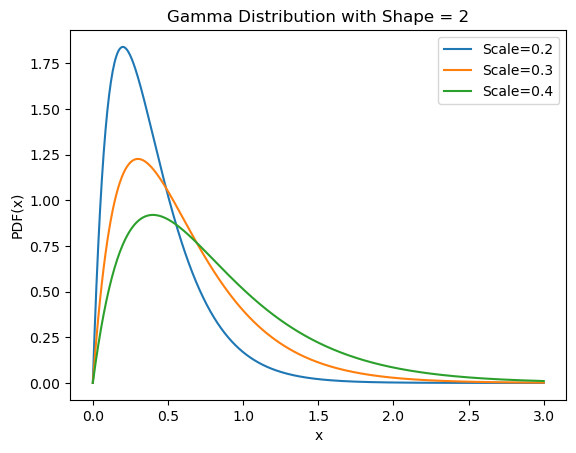

In [7]:

import matplotlib.pyplot as plt

def compute_d_radius(eps):
    return gamma(2, scale=eps)
x2= np.linspace(0, 3, 500)

for scale in [0.2, 0.3, 0.4]:
    # Generate a gamma distribution
    gamma_dist = compute_d_radius(scale)

    # Calculate the PDF values for each x-value
    pdf = gamma_dist.pdf(x2)

    # Plot the PDF
    plt.plot(x2, pdf, label=f"Scale={scale}")

plt.title("Gamma Distribution with Shape = 2")
plt.xlabel("x")
plt.ylabel("PDF(x)")
plt.legend()
plt.show()

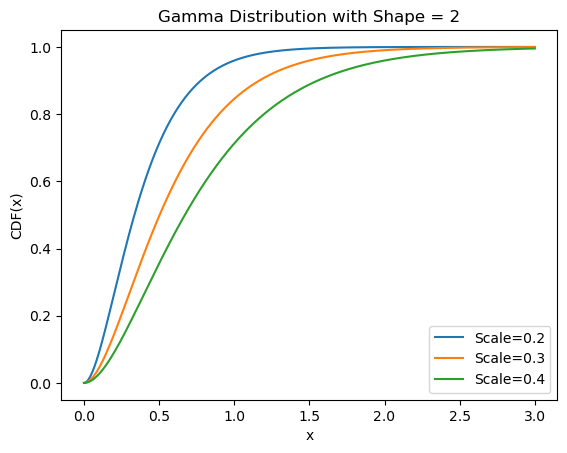

In [8]:
for scale in [0.2, 0.3, 0.4]:
    # Generate a gamma distribution
    gamma_dist = compute_d_radius(scale)

    # Calculate the PDF values for each x-value
    pdf = gamma_dist.cdf(x2)

    # Plot the PDF
    plt.plot(x2, pdf, label=f"Scale={scale}")

plt.title("Gamma Distribution with Shape = 2")
plt.xlabel("x")
plt.ylabel("CDF(x)")
plt.legend()
plt.show()

$C_\epsilon^{-1}$ is the inverse gamma CDF 

1. We modify planar laplace to include distance 


In [9]:

"""
## Compute Dr(r) 
def polar_laplace(x, x0, eps):
    ## Compute the function f(x) = (eps**2 / (2 * np.pi)) * np.exp(-eps * np.linalg.norm(x - x0))
    # Compute the Euclidean distance between x and x0
    d = np.sqrt((x[:,0] - x0[0])**2 + (x[:,1] - x0[1])**2)
    
    # Compute the function value at each x
    #return (eps**2 / (2 * np.pi)) * d * np.exp(-eps * d)
    return eps**2 * d * e * -(eps * d) 

y = polar_laplace(x, x0, eps)

import matplotlib.pyplot as plt
plt.scatter(x[:, 0], x[:, 1], c=y)
plt.colorbar()
plt.title(r'$\epsilon^2 * d(x0, x) * e^{-\epsilon d(x0, x)}$ (polar laplace)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()"""


"\n## Compute Dr(r) \ndef polar_laplace(x, x0, eps):\n    ## Compute the function f(x) = (eps**2 / (2 * np.pi)) * np.exp(-eps * np.linalg.norm(x - x0))\n    # Compute the Euclidean distance between x and x0\n    d = np.sqrt((x[:,0] - x0[0])**2 + (x[:,1] - x0[1])**2)\n    \n    # Compute the function value at each x\n    #return (eps**2 / (2 * np.pi)) * d * np.exp(-eps * d)\n    return eps**2 * d * e * -(eps * d) \n\ny = polar_laplace(x, x0, eps)\n\nimport matplotlib.pyplot as plt\nplt.scatter(x[:, 0], x[:, 1], c=y)\nplt.colorbar()\nplt.title(r'$\\epsilon^2 * d(x0, x) * e^{-\\epsilon d(x0, x)}$ (polar laplace)')\nplt.xlabel('x')\nplt.ylabel('y')\nplt.show()"

In [10]:
import math
from scipy.special import lambertw
#Convert degrees to radians
def rad_of_deg(ang):
	return np.radians(ang)

#Convert radians to degrees
def deg_of_rad(ang):
	return np.degrees(ang)

#Define Lambda distribution
def LambertW(x):
	#Min diff decides when the while loop ends
	min_diff = 1e-10
	if (x == -1 / np.e):
		return -1
	elif ((x < 0) and (x > -1/np.e)):
		q = np.log(-x)
		p = 1
		while (abs(p-q) > min_diff):
			p = (q * q + x / np.exp(q)) / (q + 1)
			q = (p * p + x / np.exp(p)) / (p + 1)
		#determine the precision of the float number to be returned
		return (np.round(1000000 * q) / 1000000)
	elif (x == 0):
		return 0
	else:
		return 0

def inverseCumulativeGamma (eps, p): 
    x = (p - 1) / np.e
    return -(LambertW(x) + 1)/eps

def polar_to_cartesian (distance, theta): 
    x, y = distance * np.cos(theta), distance * np.sin(theta)
    return x,y


def addVectorToPoint(point, distance, angle):
	x1, y1 = point
	x2 = x1 + (distance * np.cos(angle))
	y2 = y1 + (distance * np.sin(angle))
	return x2, y2



In [11]:
def generate_laplace_noise(eps, x, y): 
    theta = np.random.rand()*np.pi*2
    p = random.random()
    r = inverseCumulativeGamma(eps, p) # draw radius distance
    return addVectorToPoint([x, y], r, theta)


\begin{aligned} P_{area}=\left\{ center = x_{0},radius = \frac{1}{N}\times \sum _{i=1}^{N}r_{i}\right\} \end{aligned}

According to yanPerturbOptimizeUsers2022b

In [12]:
from math import sqrt


def calculate_radius_with_noise(x0): 
    Z = []
    total_dis = 0
    N = 10
    for nm in range(0, N):
        x1, y1 = x0
        noise = generate_laplace_noise(epsilon, x1, y1)
        x2, y2 = noise
        total_dis = total_dis + math.dist(x0, noise)
        Z.append(noise)

    R = total_dis / N
    return np.array(Z), R



In [13]:
x0 = X[1, 0], X[3, 1]
Z, R = calculate_radius_with_noise(x0)

In [14]:
print(R)

0.1257413800000001


In [15]:
def plot_noise(x0, X, Z, p_area): 
    """
        x0: starting point of the point to add noise to
        X: Original dataset
        Z: Noisy locations generated from x0 using the planar laplace mechanism.
        Parea: The area calculated based on the noise Z
    """
    fig, ax = plt.subplots()

    ax.scatter(X[:, 0], X[:,1])
    plt.xlim(np.min(X[:, 0]) - 0.3, np.max(X[:, 0]) + 0.3)
    plt.ylim(np.min(X[:, 1]) - 0.1, np.max(X[:, 1]) + 0.3)
    ax.scatter(x0[0], x0[1], color='yellow', marker='o')
    circle = plt.Circle((x0[0], x0[1]), p_area * np.pi, color='black', fill=False)
    ax.add_artist(circle)
    # ax.set_aspect('equal', adjustable='datalim')

    ax.scatter(Z[:, 0], Z[:,1], color='red')

    plt.show()

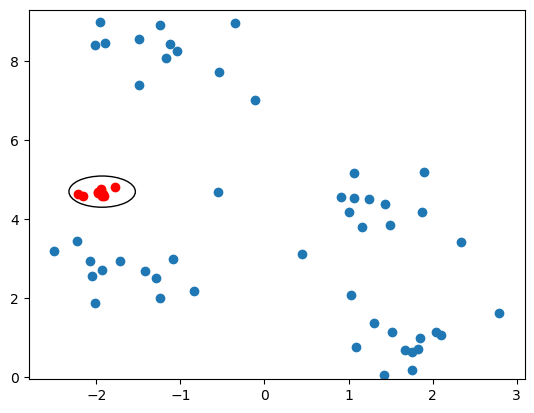

In [16]:
plot_noise(x0, X, Z, R)

## Truncation
Because we have a finite space, it can be possible the pertubed points are off-graph (outside the given domain). 
The solution  was described in step 5 of the Laplacian mechanism for 2D space. This explains the idea of remapping to the closest admissible location in the set A. 
For which $A \subset \mathbb{R^2}$, where A is the set of admissible locations (Cite andres). 
This is also more clearly described by chatzikokolakisEfficientUtilityImprovement2017, where they also describe a method to do it. When a pertrubed point $z$ is located at the sea or in water, it is easily distuinguishable as a fake location. They introduce a method to check this and efficiently remap to a nearby *real* location.

The methods proposed work correct for a scenario where other locations for remapping are available (as with a geographic map).
However, for the porpose of non-geographical data; such point may not be available. 
For this reason we propse a different way of handling this, which is more straightforward for non-geographical data:


1. Detect if the $P_{area}$ is outside the domain. If it is, we run the truncation algorithm. This is just an optimalization step
2. Run the truncation algoritm 

$T(x_{max}, x_{min}, z, x_0) = \begin{cases} z &\text{if n=0} \\ T(x_{max}, x_{min}, planarLaplace(epsilon, x_0), x_0)  &\text{else} \end{cases}$

So the algoritm works recursively. It detects wether a perturbed point $z$ is outside the bounds of the domain $x_{max} \in X$ and $x_{min} \in X$.
If it is, we re-run the truncation until all points are within the radius. A disadvantage of the approach is that the privacy is degrated due to a cut-off of the pricacy radius $r$. In addition to this, the algoritm is heavy as it could potentially regenerate infinitely.
Therefore, there are two optimalisation steps to take:
1. We should select only the part of the radius that is within the given domain. We should be-able to recalculate the radius to be within the domain and re-assign the points using the $planarLaplace$ method, instead of recursively trying it again.
2. This degrades the privacy of this point, but to a trade-off of having all points within the radius without modyfing the notion of geo-indistuinghishability 

In [17]:
X[12, 1]

0.0456528976305518

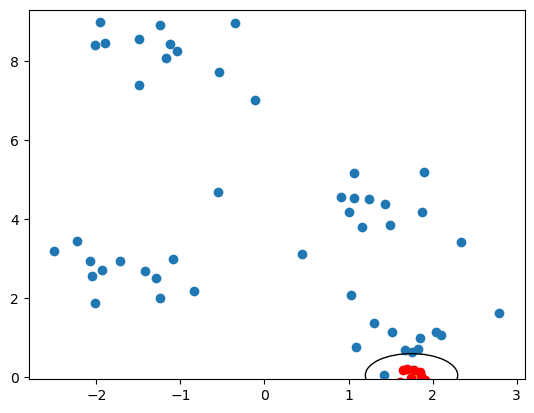

[[ 1.61660594 -0.11492296]
 [ 1.60323546 -0.23414419]
 [ 1.64637804  0.18057436]
 [ 1.69622129  0.20582084]
 [ 1.73781673 -0.03211401]
 [ 1.90531876 -0.07563481]
 [ 1.85357695  0.12072145]
 [ 1.83940609 -0.16234551]
 [ 1.77625223  0.18321538]
 [ 1.86197681  0.03003897]]


In [18]:
# Plot a point outside the boundary (we selected a specific point based on above information)
x0 = [X[36, 0], X[12, 1]]
Z1, R1 = calculate_radius_with_noise(x0)
plot_noise(x0, X, Z1, R1)
print(Z1)

In [19]:
def truncate(x_max, x_min, x0, z): 
    x2, y2 = x_max
    x1, y1 = x_min

    zx, zy = z
    if(x1 < zx < x2 and y1 < zy < y2): 
        # print('inside', x, y)
        return z
    else:
        x, y = x0
        z2 = generate_laplace_noise(epsilon, x, y)
        print('outside', zx, zy)  
        return truncate(x_max, x_min, x0, z2)

def truncate_array(x0, X, Z): 
    truncatedZ1 = []
    x_max = [np.max(X[:, 0]), np.max(X[:, 1])]
    x_min = [np.min(X[:, 0]), np.min(X[:, 1])]
    for z in Z:
        truncatedZ1.append(truncate(x_max, x_min, x0, z))

    return np.array(truncatedZ1)

In [20]:
Z2 = truncate_array(x0, X, Z1)

outside 1.6166059371048824 -0.1149229637480216
outside 1.7016081566118886 0.02927449195358415
outside 1.6032354646555491 -0.234144191841188
outside 1.7378167337973092 -0.0321140058516859
outside 1.9053187624055683 -0.07563481057708114
outside 1.7003651365200674 -0.283338536013272
outside 1.5365446144701111 -0.014246671314517283
outside 1.8634891598442604 0.023764830412961624
outside 1.8394060928164755 -0.16234551406932582
outside 1.6898642960165675 0.04369994605891424
outside 1.8619768087843547 0.03003896796209783
outside 1.7392904691426259 -0.03398448718397132


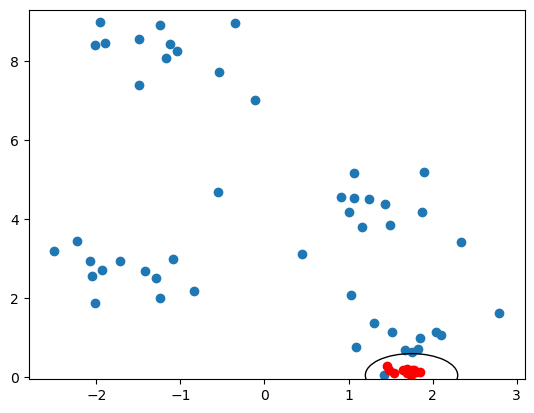

In [21]:

plot_noise(x0, X, Z2, R1)

In [22]:
truncatedZ


NameError: name 'truncatedZ' is not defined

Calculating the probability density function

In [ ]:
def probabilityDensity(x, x0, eps):
    
    # Compute the Euclidean distance between x and x0
    d = np.sqrt((x[:,0] - x0[0])**2 + (x[:,1] - x0[1])**2)
    
    # Compute the function value at each x
    return (eps**2 / (2 * np.pi)) * e * -(eps * d)


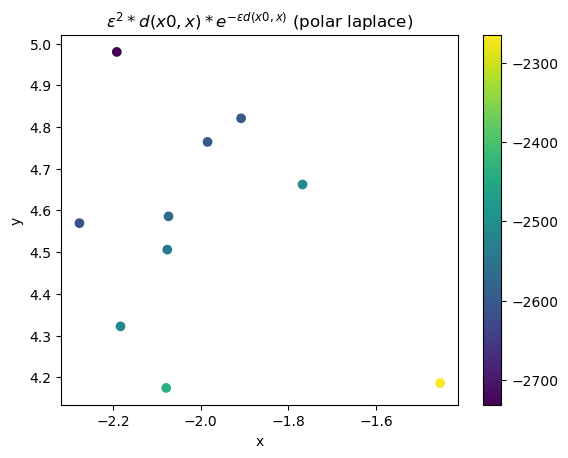

In [ ]:
plt.scatter(Z[:, 0], Z[:, 1], c=probabilityDensity(Z, x0, epsilon))
plt.colorbar()
plt.title(r'$\epsilon^2 * d(x0, x) * e^{-\epsilon d(x0, x)}$ (polar laplace)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Discretization
1. Draw a point $(r, \theta)$ (see r_theta)
2. Remap the point to closest point x on G

In [ ]:
from scipy.integrate import quad

""" r = distance """
def radius (r): 
    return 2 * eps * r * np.exp(-eps * r)

""" r = theta """
def theta (r): 
    return 2 * eps * r * np.exp(-eps * r)

def draw_radius(r): 

    result, error = quad(radius, 0, 2*np.pi)
    return result

def draw_theta(r):
    result, error = quad(theta, 0, np.Infinity)
    return result

def add_polar_coords(point_to_sanitize, r, theta):
    """
    Add polar coordinates (r, theta) to a vector x, where theta is in radians.
    """
    y = point_to_sanitize + r * np.column_stack((np.cos(theta), np.sin(theta)))
    return y


In [ ]:
other_locations = np.random.randn(50, 2)
point_of_interest = [1, 2]
p = np.random.uniform(0, 1)
theta = random.uniform(0, 2*math.pi)
dist = np.linalg.norm(point_of_interest-other_locations)

radius = draw_radius(dist)
d__r_theta = radius * theta
#r = np.linalg.norm(point_of_interest - other_locations)
#R = polar_laplace(r)
#print(theta, p)
print(d__r_theta, radius, theta)

NameError: name 'eps' is not defined

In [ ]:
from scipy.stats import gamma, uniform

r_generator = gamma(2., scale=1 / eps)
theta_generator = uniform(scale=2 * np.pi)


In [ ]:
r = r_generator.rvs()
theta = theta_generator.rvs()

In [ ]:
np.cos(theta) * r, np.sin(theta) * r

(7.633838282763048, -3.8058093886495885)

## Visualize

NameError: name 'testVector' is not defined

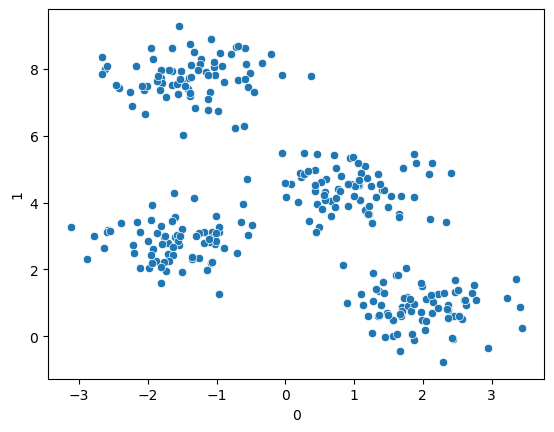

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 


# Plot the data as a scatter plot
fig, ax = plt.subplots()
sns.scatterplot(x=df.iloc[:, 0], y=df.iloc[:, 1])

# Choose a point and a radius
center = (0, testVector['x'])
radius = 0.5

# Draw a circle around the chosen point
circle = plt.Circle(center, radius, color='r', fill=False)
plt.gca().add_artist(circle)

plt.show()